[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver


from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipykernel_2289124/3367306228.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Define the objective function and the gradient of the objective

*   Import the geometry, mesh
*   Build the FEA model
*   Build the SSO model



Import the data needed

In [59]:
#Import the geometry, mesh and fixed node info
local_path = '../Data/Mannheim_Triangle/' #path of the file
df = pd.read_csv(local_path + 'Mesh.csv') #Connectivity matrix
cnct = df.to_numpy() #convert to numpy array
df2 = pd.read_csv(local_path + 'Coordinate.csv') #Coordinate
crd = df2.to_numpy() #convert to numpy array
df3 = pd.read_csv(local_path + 'fixed_nodes.csv') #Connectivity matrix
fixed_nodes = df3.to_numpy().reshape(-1) #convert to numpy array

#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

In [60]:
import trimesh

mesh = trimesh.Trimesh(vertices=crd,
                       faces=[[0, 1, 2]])

In [61]:
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
    design_nodes.append(i)
    z_nodes[i] = np.random.uniform(0.7,0.701)#random_z
  else:
    z_nodes[i] = 0
fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))


for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

# Mid-point of each member
mid_x = np.average(x_ele,axis=1)
mid_y = np.average(y_ele,axis=1)
mid_z = np.average(z_ele,axis=1)

design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))

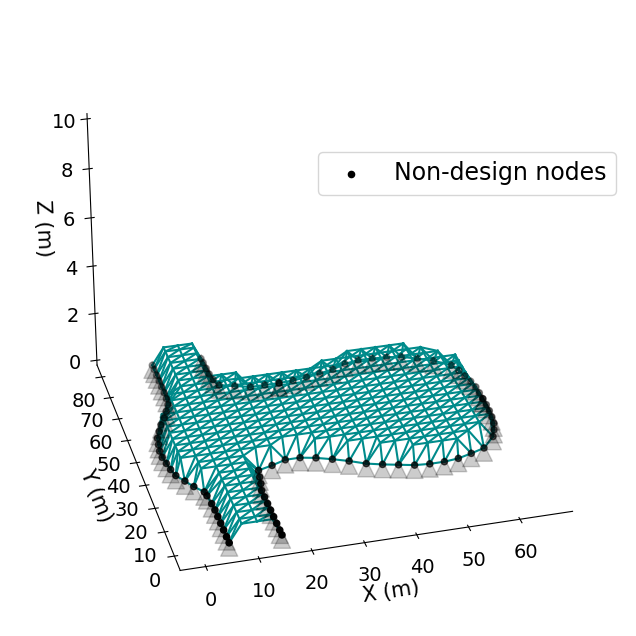

In [62]:

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

# Geodesic info

In [63]:
# Inputs of NN
# Embed some info
# 1. X,Y COORDINATES
# 2. Distance to the boundary: how close they are to the boundary
# 3. Centrality
from jax import vmap
def dis_boundary(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the minimum distance of each node to the boundary node
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    return jnp.min(vmap_norm(crd_xy,bound_xy),axis=1)

def v_centrality(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the vertex centrality. Normalized so that maximum is "1".
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    
    return jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1)/jnp.max(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))

In [64]:
dis_b = dis_boundary(x_nodes,y_nodes,non_design_nodes)[design_nodes]
v_cen = v_centrality(x_nodes,y_nodes,non_design_nodes)[design_nodes]

## Create FEA model

In [65]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area
load = 100000/10 #Pt load

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 


# SSO model based on FEA model

In [66]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [67]:
%timeit sso_model.value_grad_params(which_solver='dense',enforce_scipy_sparse = True)

16.1 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# A simple NN built with Flax

In [68]:
import pymesh
from flax import linen as nn

Input of NN:
vertex crds

Output of NN:
nodal movement (Z)

## Simple Neural Network

In [69]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [70]:
n_input = 3 #(X,Y,dis_b,v_centrality) of each node
n_hidden = 500 # neurons
n_out = 1 #Z of each node
n_layers =2 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.array([x_nodes[design_nodes],y_nodes[design_nodes],dis_b]).T
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [71]:
inp.shape

(348, 3)

In [72]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [73]:
print(NN)

SimpleNN(
    # attributes
    num_hidden = 500
    num_outputs = 1
    num_layers = 2
)


In [74]:
import jax
import jax.numpy as jnp  # JAX NumPy


print(NN.tabulate(rng,inp,
                   compute_flops=True, compute_vjp_flops=True))


                                SimpleNN Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs    ┃ outputs   ┃ flops    ┃ vjp_flops ┃ params   ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│         │ SimpleNN │ float64[… │ float64[… │ 1763413… │ 528674784 │          │
├─────────┼──────────┼───────────┼───────────┼──────────┼───────────┼──────────┤
│ Dense_0 │ Dense    │ float64[… │ float64[… │ 1220000  │ 3485500   │ bias:    │
│         │          │           │           │          │           │ float32… │
│         │          │           │           │          │           │ kernel:  │
│         │          │           │           │          │           │ float32… │
│         │          │           │           │          │           │          │
│         │          │           │           │          │           │ 2,000    │
│         │          │     

In [75]:
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [76]:
NN.apply(params,inp).reshape(-1).shape

(348,)

## Optimizer

In [77]:
import optax
optimizer = optax.adamw(learning_rate=0.001,weight_decay=1e-4)

In [78]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

## Loss Function

Pipeline ML with Jax-SSO to get the loss function.

Test if $d(loss)/d(params)$ work

In [79]:
def calculate_loss(state, params, inp):
    
    ##Apply_fn: ML input to output
    z_new = state.apply_fn(params, inp).reshape(-1) #Z-coordinate, ML-Output
    
    #ML output to loss through Jax-SSO
    sso_model.update_nodeparameter(z_new)
    loss = sso_model.params_to_objective()
     
    return loss#+jnp.norm(z_new)


## Training Step and Training

In [80]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [81]:
%timeit train_step(model_state, inp)

46 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
def train_model(state, num_epochs=2000):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        state, loss = train_step(state, inp)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
    return state

In [83]:
trained_model_state = train_model(model_state, num_epochs=200)

  2%|▏         | 3/200 [00:00<00:09, 21.21it/s]

Train epoch 2  ,loss:9077.355541811743
Train epoch 3  ,loss:729.1956592770786
Train epoch 4  ,loss:836.5632566742781
Train epoch 5  ,loss:713.9769521145556
Train epoch 6  ,loss:712.2361103066539


  3%|▎         | 6/200 [00:00<00:09, 20.95it/s]

Train epoch 7  ,loss:824.6635461066103
Train epoch 8  ,loss:772.2412638663353
Train epoch 9  ,loss:754.317142841729


  4%|▍         | 9/200 [00:00<00:09, 20.78it/s]

Train epoch 10  ,loss:786.5095256077312
Train epoch 11  ,loss:815.3005219288032


  6%|▌         | 12/200 [00:00<00:09, 20.67it/s]

Train epoch 12  ,loss:809.5356003436775
Train epoch 13  ,loss:788.4625195011306
Train epoch 14  ,loss:780.7279981473355


  8%|▊         | 15/200 [00:00<00:08, 20.70it/s]

Train epoch 15  ,loss:787.3821506390748
Train epoch 16  ,loss:796.2769706629372


  9%|▉         | 18/200 [00:00<00:08, 20.71it/s]

Train epoch 17  ,loss:792.7928732548048
Train epoch 18  ,loss:778.85820143354
Train epoch 19  ,loss:767.8710051435106
Train epoch 20  ,loss:761.6899755166017
Train epoch 21  ,loss:759.0954137364902


 10%|█         | 21/200 [00:01<00:08, 20.66it/s]

Train epoch 22  ,loss:753.5884582897784
Train epoch 23  ,loss:741.6542171666613
Train epoch 24  ,loss:726.4318722931495


 12%|█▏        | 24/200 [00:01<00:08, 20.61it/s]

Train epoch 25  ,loss:715.4294273200284
Train epoch 26  ,loss:711.729956103736


 14%|█▎        | 27/200 [00:01<00:08, 20.62it/s]

Train epoch 27  ,loss:704.4308004560162
Train epoch 28  ,loss:687.4060362220606
Train epoch 29  ,loss:676.5472800087916


 15%|█▌        | 30/200 [00:01<00:08, 20.64it/s]

Train epoch 30  ,loss:670.3500626838494
Train epoch 31  ,loss:657.0652698287199


 16%|█▋        | 33/200 [00:01<00:08, 20.63it/s]

Train epoch 32  ,loss:640.8767112001001
Train epoch 33  ,loss:632.0566264440189
Train epoch 34  ,loss:620.4543037697063
Train epoch 35  ,loss:603.4047088288719
Train epoch 36  ,loss:592.7924732564759


 18%|█▊        | 36/200 [00:01<00:07, 20.56it/s]

Train epoch 37  ,loss:581.8431438381258
Train epoch 38  ,loss:566.1812918852426
Train epoch 39  ,loss:553.2459756492788


 20%|█▉        | 39/200 [00:01<00:07, 20.58it/s]

Train epoch 40  ,loss:542.4527400809445
Train epoch 41  ,loss:528.6458538850395


 21%|██        | 42/200 [00:02<00:07, 20.62it/s]

Train epoch 42  ,loss:518.8581201129412
Train epoch 43  ,loss:507.8563290915098
Train epoch 44  ,loss:495.545360048705


 22%|██▎       | 45/200 [00:02<00:07, 20.67it/s]

Train epoch 45  ,loss:485.64463660072784
Train epoch 46  ,loss:473.79661164692584


 24%|██▍       | 48/200 [00:02<00:07, 20.74it/s]

Train epoch 47  ,loss:462.9528271196715
Train epoch 48  ,loss:451.3960968395721
Train epoch 49  ,loss:439.7816405291376
Train epoch 50  ,loss:428.59595709699556
Train epoch 51  ,loss:417.33707229594114


 26%|██▌       | 51/200 [00:02<00:07, 20.74it/s]

Train epoch 52  ,loss:404.22504868633325
Train epoch 53  ,loss:388.5658133389878
Train epoch 54  ,loss:371.5000408593309


 27%|██▋       | 54/200 [00:02<00:07, 20.83it/s]

Train epoch 55  ,loss:354.8014317156719
Train epoch 56  ,loss:336.0349342831813


 28%|██▊       | 57/200 [00:02<00:06, 20.89it/s]

Train epoch 57  ,loss:315.90763881049065
Train epoch 58  ,loss:305.03438417572625
Train epoch 59  ,loss:302.9730056761704


 30%|███       | 60/200 [00:02<00:06, 20.92it/s]

Train epoch 60  ,loss:357.0475682920394
Train epoch 61  ,loss:580.8115427540324


 32%|███▏      | 63/200 [00:03<00:06, 20.86it/s]

Train epoch 62  ,loss:550.7293879912567
Train epoch 63  ,loss:455.5219384401711
Train epoch 64  ,loss:243.65528788079013
Train epoch 65  ,loss:860.169892768573
Train epoch 66  ,loss:295.95765845346784


 33%|███▎      | 66/200 [00:03<00:06, 20.92it/s]

Train epoch 67  ,loss:532.4358535590056
Train epoch 68  ,loss:444.6082216737973
Train epoch 69  ,loss:260.1401497229714


 34%|███▍      | 69/200 [00:03<00:06, 21.05it/s]

Train epoch 70  ,loss:361.01961010056925
Train epoch 71  ,loss:253.3682228256989


 36%|███▌      | 72/200 [00:03<00:06, 20.97it/s]

Train epoch 72  ,loss:307.5486863410549
Train epoch 73  ,loss:242.52430021351313
Train epoch 74  ,loss:242.81440089785883


 38%|███▊      | 75/200 [00:03<00:05, 20.94it/s]

Train epoch 75  ,loss:299.84837309761963
Train epoch 76  ,loss:225.06299267855496


 39%|███▉      | 78/200 [00:03<00:05, 20.83it/s]

Train epoch 77  ,loss:276.99973983376526
Train epoch 78  ,loss:261.01942606959904
Train epoch 79  ,loss:199.4080258963334
Train epoch 80  ,loss:321.0275193709351
Train epoch 81  ,loss:223.12173465314154


 40%|████      | 81/200 [00:03<00:05, 20.89it/s]

Train epoch 82  ,loss:304.9004465030286
Train epoch 83  ,loss:251.28747004738764
Train epoch 84  ,loss:207.2442753000259


 42%|████▏     | 84/200 [00:04<00:05, 20.99it/s]

Train epoch 85  ,loss:316.3881527638465
Train epoch 86  ,loss:208.18167672646433


 44%|████▎     | 87/200 [00:04<00:05, 20.94it/s]

Train epoch 87  ,loss:254.78745683539614
Train epoch 88  ,loss:263.2396964036276
Train epoch 89  ,loss:212.14437249872208


 45%|████▌     | 90/200 [00:04<00:05, 21.00it/s]

Train epoch 90  ,loss:223.9732186422712
Train epoch 91  ,loss:236.99374388643304


 46%|████▋     | 93/200 [00:04<00:05, 20.94it/s]

Train epoch 92  ,loss:201.99449310327793
Train epoch 93  ,loss:228.39940944889855
Train epoch 94  ,loss:220.9150702934103
Train epoch 95  ,loss:191.21574819613465
Train epoch 96  ,loss:227.49403652854187


 48%|████▊     | 96/200 [00:04<00:04, 20.94it/s]

Train epoch 97  ,loss:186.01261717451777
Train epoch 98  ,loss:207.24441102769302
Train epoch 99  ,loss:194.75253291753592


 50%|████▉     | 99/200 [00:04<00:04, 21.00it/s]

Train epoch 100  ,loss:186.49302479008446
Train epoch 101  ,loss:196.2247187651979


 51%|█████     | 102/200 [00:04<00:04, 21.08it/s]

Train epoch 102  ,loss:180.06874093961977
Train epoch 103  ,loss:194.97592792014
Train epoch 104  ,loss:174.11194378256255


 52%|█████▎    | 105/200 [00:05<00:04, 21.15it/s]

Train epoch 105  ,loss:192.37299558596916
Train epoch 106  ,loss:193.50076938760878


 54%|█████▍    | 108/200 [00:05<00:04, 21.25it/s]

Train epoch 107  ,loss:187.4794070004993
Train epoch 108  ,loss:199.94853827856468
Train epoch 109  ,loss:162.2334374049297
Train epoch 110  ,loss:168.7746880037234
Train epoch 111  ,loss:169.87562854779463


 56%|█████▌    | 111/200 [00:05<00:04, 21.12it/s]

Train epoch 112  ,loss:173.04285223066836
Train epoch 113  ,loss:174.21061964112027
Train epoch 114  ,loss:154.49918699973546


 57%|█████▋    | 114/200 [00:05<00:04, 21.13it/s]

Train epoch 115  ,loss:165.93088890647198
Train epoch 116  ,loss:172.1708811577094


 58%|█████▊    | 117/200 [00:05<00:03, 21.17it/s]

Train epoch 117  ,loss:167.48728396326752
Train epoch 118  ,loss:171.70316743717433
Train epoch 119  ,loss:155.8607107017271


 60%|██████    | 120/200 [00:05<00:03, 21.23it/s]

Train epoch 120  ,loss:150.99226430499738
Train epoch 121  ,loss:170.76466870154582


 62%|██████▏   | 123/200 [00:05<00:03, 21.32it/s]

Train epoch 122  ,loss:205.31152045414717
Train epoch 123  ,loss:146.91015444976694
Train epoch 124  ,loss:224.98173300269605
Train epoch 125  ,loss:353.216839313421
Train epoch 126  ,loss:282.3631816174658


 63%|██████▎   | 126/200 [00:06<00:03, 21.23it/s]

Train epoch 127  ,loss:311.20102012987905
Train epoch 128  ,loss:241.0040178644241
Train epoch 129  ,loss:298.31528874079095


 64%|██████▍   | 129/200 [00:06<00:03, 21.11it/s]

Train epoch 130  ,loss:180.19216501842834
Train epoch 131  ,loss:379.02814874622453


 66%|██████▌   | 132/200 [00:06<00:03, 20.93it/s]

Train epoch 132  ,loss:341.16157936714916
Train epoch 133  ,loss:537.6624702775515
Train epoch 134  ,loss:302.95177371324803


 68%|██████▊   | 135/200 [00:06<00:03, 21.04it/s]

Train epoch 135  ,loss:262.17618798259593
Train epoch 136  ,loss:576.9342938759938


 69%|██████▉   | 138/200 [00:06<00:02, 20.94it/s]

Train epoch 137  ,loss:647.7981706441
Train epoch 138  ,loss:1326.0897542775751
Train epoch 139  ,loss:1357.3488740598805
Train epoch 140  ,loss:1007.720230579899
Train epoch 141  ,loss:553.4755166782048


 70%|███████   | 141/200 [00:06<00:02, 20.88it/s]

Train epoch 142  ,loss:410.2631907633194
Train epoch 143  ,loss:1170.459314979913
Train epoch 144  ,loss:384.5042128831765


 72%|███████▏  | 144/200 [00:06<00:02, 20.95it/s]

Train epoch 145  ,loss:659.2739752917423
Train epoch 146  ,loss:912.8913922359561


 74%|███████▎  | 147/200 [00:07<00:02, 20.79it/s]

Train epoch 147  ,loss:1003.1879552772805
Train epoch 148  ,loss:959.0379994712347
Train epoch 149  ,loss:816.1479832221899


 75%|███████▌  | 150/200 [00:07<00:02, 20.75it/s]

Train epoch 150  ,loss:594.3075399107795
Train epoch 151  ,loss:407.1788179975963


 76%|███████▋  | 153/200 [00:07<00:02, 20.99it/s]

Train epoch 152  ,loss:528.3188120377672
Train epoch 153  ,loss:697.4236056449347
Train epoch 154  ,loss:511.4036249478022
Train epoch 155  ,loss:398.85649494228977
Train epoch 156  ,loss:464.85058941644024


 78%|███████▊  | 156/200 [00:07<00:02, 20.90it/s]

Train epoch 157  ,loss:543.9909158950629
Train epoch 158  ,loss:561.4855594470187
Train epoch 159  ,loss:512.9249135608526


 80%|███████▉  | 159/200 [00:07<00:01, 20.87it/s]

Train epoch 160  ,loss:425.88366838677155
Train epoch 161  ,loss:370.9439337651367


 81%|████████  | 162/200 [00:07<00:01, 21.03it/s]

Train epoch 162  ,loss:397.82327042227917
Train epoch 163  ,loss:447.5469003028045
Train epoch 164  ,loss:395.63095955585777


 82%|████████▎ | 165/200 [00:07<00:01, 21.06it/s]

Train epoch 165  ,loss:327.7764268126532
Train epoch 166  ,loss:326.9717220822297


 84%|████████▍ | 168/200 [00:08<00:01, 21.07it/s]

Train epoch 167  ,loss:353.3844804014923
Train epoch 168  ,loss:359.08382159816006
Train epoch 169  ,loss:327.8719504949895
Train epoch 170  ,loss:292.9579355497815
Train epoch 171  ,loss:289.87876489986377


 86%|████████▌ | 171/200 [00:08<00:01, 20.85it/s]

Train epoch 172  ,loss:325.5183447412318
Train epoch 173  ,loss:278.6437559306705
Train epoch 174  ,loss:270.1818510446879


 87%|████████▋ | 174/200 [00:08<00:01, 20.95it/s]

Train epoch 175  ,loss:276.35937201777153
Train epoch 176  ,loss:283.95087910152745


 88%|████████▊ | 177/200 [00:08<00:01, 20.94it/s]

Train epoch 177  ,loss:274.0407715232309
Train epoch 178  ,loss:259.18527702933136
Train epoch 179  ,loss:253.12386145667728


 90%|█████████ | 180/200 [00:08<00:00, 21.02it/s]

Train epoch 180  ,loss:262.5237351299594
Train epoch 181  ,loss:257.51195524734436


 92%|█████████▏| 183/200 [00:08<00:00, 21.01it/s]

Train epoch 182  ,loss:241.37562430797382
Train epoch 183  ,loss:238.69809547806875
Train epoch 184  ,loss:240.4332261854505
Train epoch 185  ,loss:234.72889271438413
Train epoch 186  ,loss:224.74488098185856


 93%|█████████▎| 186/200 [00:08<00:00, 20.90it/s]

Train epoch 187  ,loss:221.68805466243214
Train epoch 188  ,loss:225.94430103971598
Train epoch 189  ,loss:216.8663257593698


 94%|█████████▍| 189/200 [00:09<00:00, 20.98it/s]

Train epoch 190  ,loss:212.09138744875156
Train epoch 191  ,loss:213.58439349858406


 96%|█████████▌| 192/200 [00:09<00:00, 21.01it/s]

Train epoch 192  ,loss:209.7668738782363
Train epoch 193  ,loss:202.3155718607348
Train epoch 194  ,loss:202.40447211795646


 98%|█████████▊| 195/200 [00:09<00:00, 21.07it/s]

Train epoch 195  ,loss:201.0034477671206
Train epoch 196  ,loss:195.16882500023408


 99%|█████████▉| 198/200 [00:09<00:00, 21.09it/s]

Train epoch 197  ,loss:196.28250840999868
Train epoch 198  ,loss:194.62111155389337
Train epoch 199  ,loss:189.890867342961


100%|██████████| 200/200 [00:09<00:00, 20.93it/s]

Train epoch 200  ,loss:190.8229434546525
Train epoch 201  ,loss:186.8776969672748


# This example does not make too much engineering sense: it is essentially gradient descent with FEA+ANN. But it shows how simple it is to incorporate JaxSSO in ML framework.

In [86]:
##Apply_fn: ML input to output
z_new = trained_model_state.apply_fn(trained_model_state.params, inp).reshape(-1) #how to move nodes along z, ML-Outpu

#ML output to loss through Jax-SSO
z_nodes[design_nodes] = -z_new

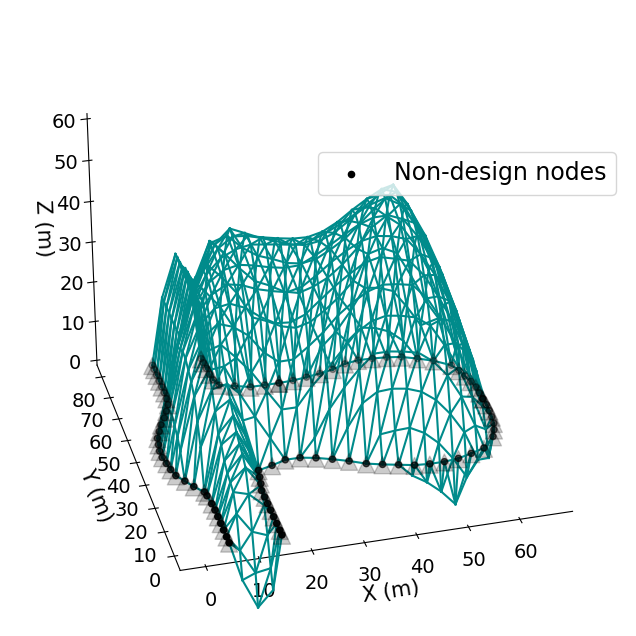

In [87]:
#Update the nodes
%matplotlib inline
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,60)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()